<h1> Setup Environment </h1>
Necessary imports and environment variables.

In [1]:
import os
import torch
import random

import matplotlib.pyplot as plt
import torchvision.transforms as T

from models import CNN, ViT
from trainers import SimCLRTrainer, DINOTrainer
from datasets import get_mnist_loaders, get_cifar10_loaders, get_imagenet_loaders, get_imagenette_loaders
from torch.utils.data import random_split, DataLoader, Subset
from tqdm.notebook import tqdm


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print your GPU name


True
NVIDIA GeForce RTX 3070


<h1> Parameters for Model and Training </h1>
Parameters for model and training.

In [2]:
# Model parameters
chw = (3, 192, 192)
n_patches = 12
hidden_d = 384
n_heads = 6
n_blocks = 12
n_classes = 1000

# Training parameters
n_epochs = 3
patience = 100
eval_every = 1
visualize_every = 10
num_workers = 1
batch_size = 32

<h1> Train Model</h1>
Model and trainer initialization, data loading, and training.

In [3]:
model = ViT(
    chw=chw, 
    n_patches=n_patches, 
    n_blocks=n_blocks, 
    hidden_d=hidden_d, 
    n_heads=n_heads, 
    num_classes=n_classes
).to('cuda')

trainer = DINOTrainer(model)

train_loader, test_loader = get_imagenet_loaders(batch_size=batch_size, num_workers=num_workers)

trainer.finetune(
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=n_epochs,
    visualize_every=visualize_every,
    evaluate_every=eval_every,
    patience=patience,
    checkpoint_path='checkpoints/my_experiment',
    resume_from='checkpoints/my_experiment/latest_checkpoint.pt'
)

Loading checkpoint from checkpoints/my_experiment/latest_checkpoint.pt
Resuming from epoch 3 with best accuracy 37.45%


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/40037 [00:04<?, ?it/s]

Checkpoint saved to checkpoints/my_experiment\checkpoint_epoch_1_20250213_035402.pt


Training Epoch 2:   0%|          | 0/40037 [00:03<?, ?it/s]

Checkpoint saved to checkpoints/my_experiment\checkpoint_epoch_2_20250213_055425.pt


Training Epoch 3:   0%|          | 0/40037 [00:03<?, ?it/s]

Checkpoint saved to checkpoints/my_experiment\checkpoint_epoch_3_20250213_075457.pt


{'train_loss': [4.988625411832178,
  3.8224220446358665,
  3.2997945152081867,
  3.054157366017068,
  2.8685934993685205,
  2.722932675937811,
  2.601338477039068,
  2.499146600347461],
 'train_acc': [11.800725432359716,
  24.3639587969406,
  31.93463459486546,
  35.71431359065602,
  38.67380286879072,
  41.12937657619967,
  43.11420759354557,
  44.88072202921243],
 'test_acc': [18.39, 26.388, 31.708, 35.892, 37.454, 39.654, 41.716, 42.948],
 'lr': [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]}

<h1> Visualize Attention Map </h1>


Image 9932 class: standard schnauzer (index: 198)


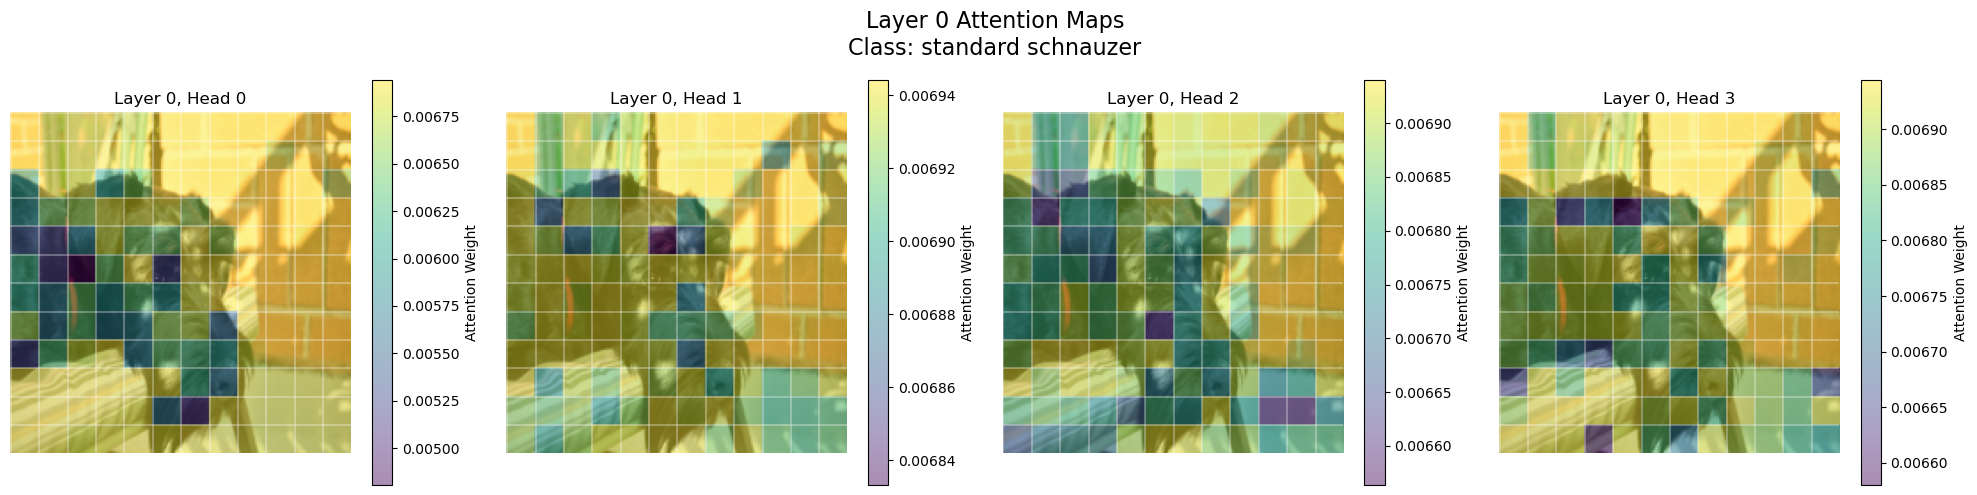

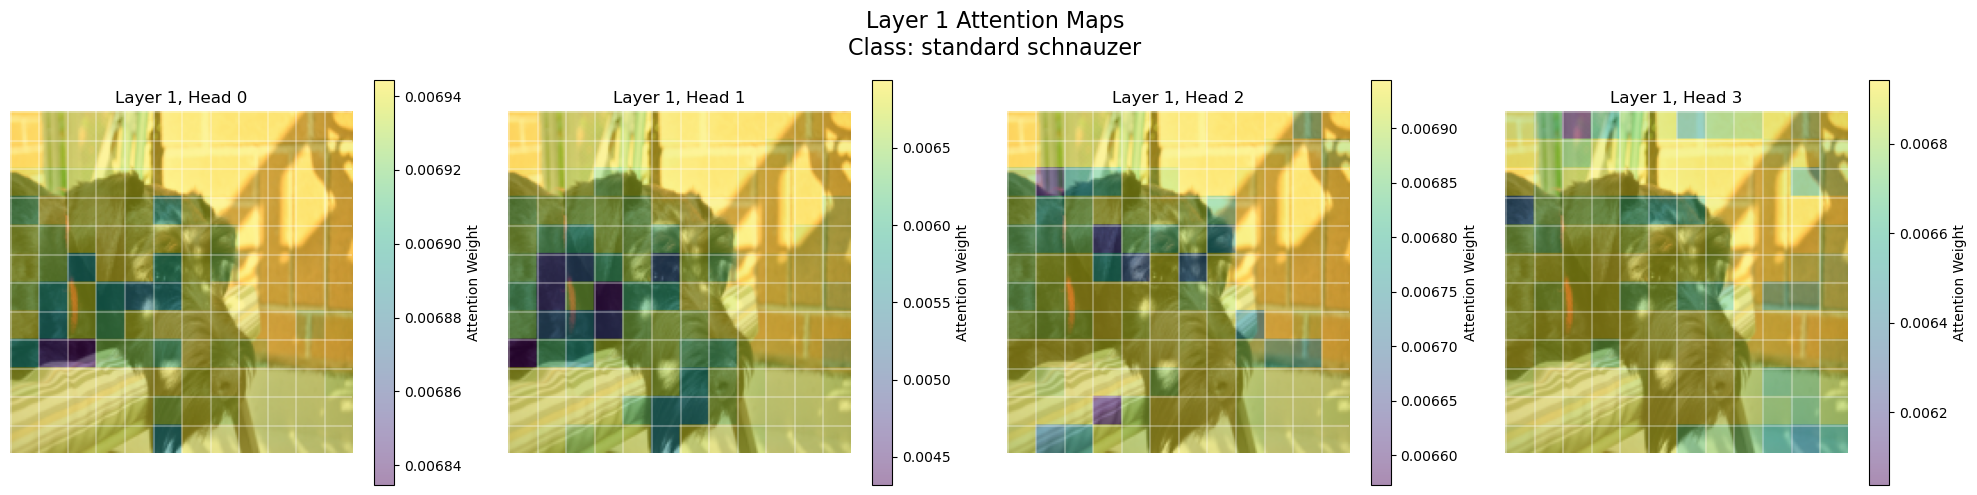

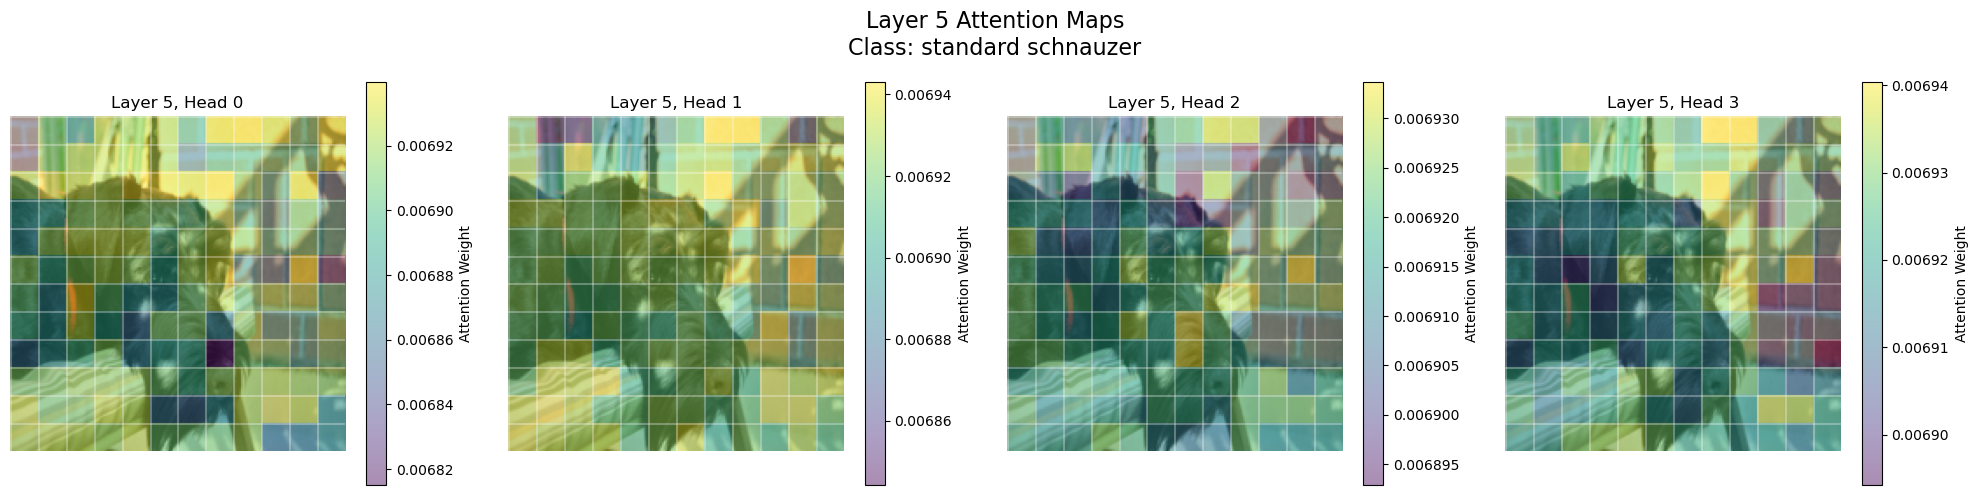

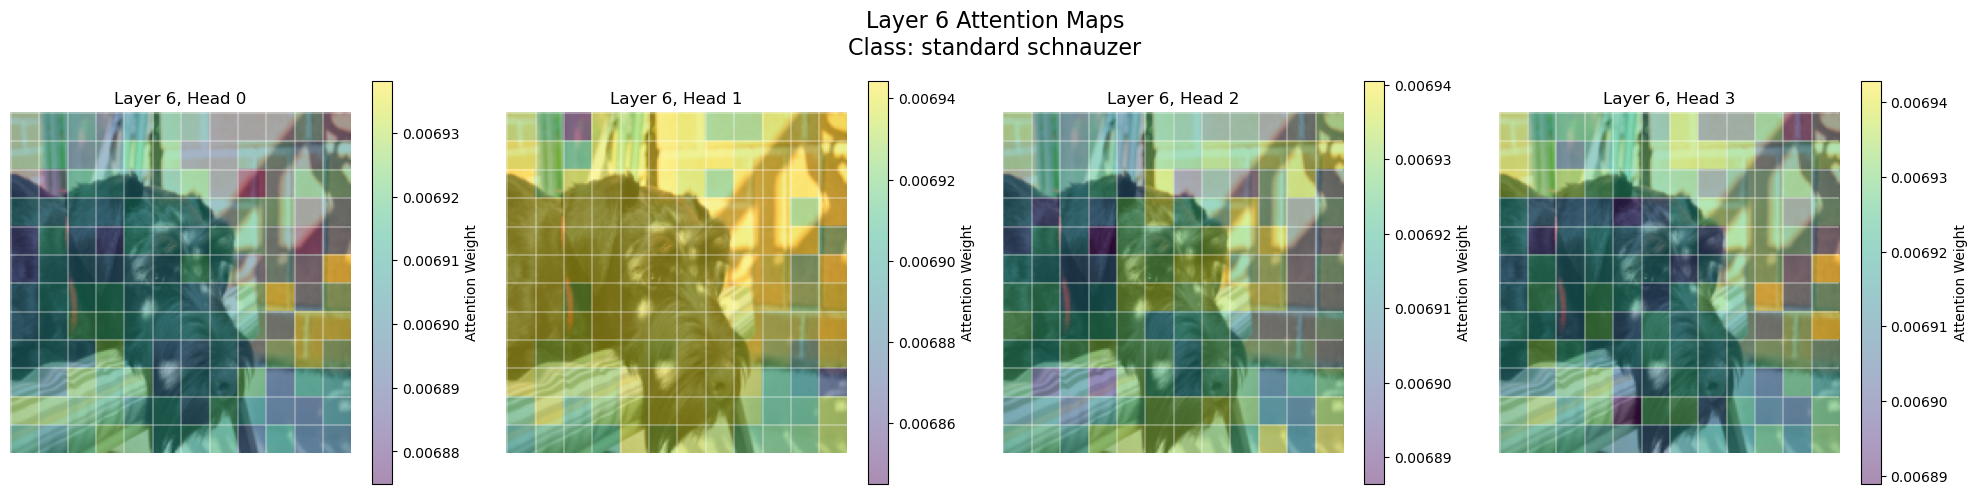

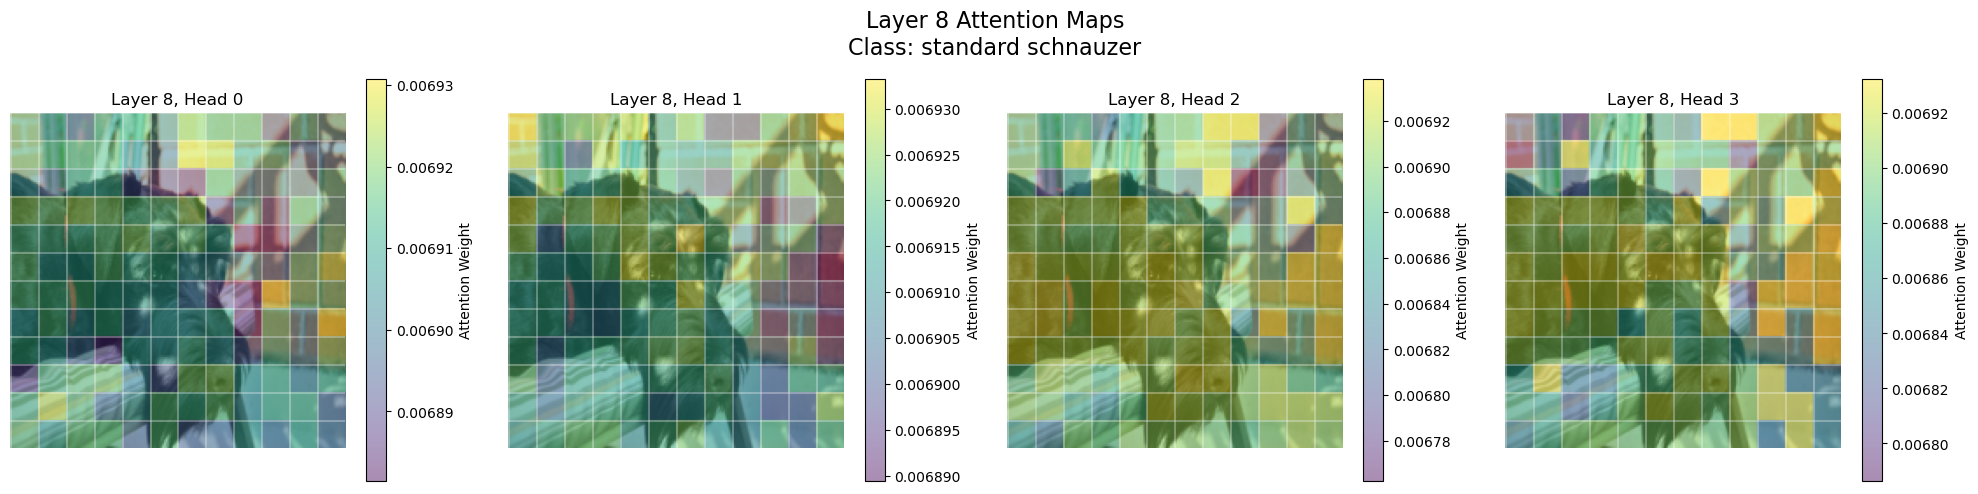

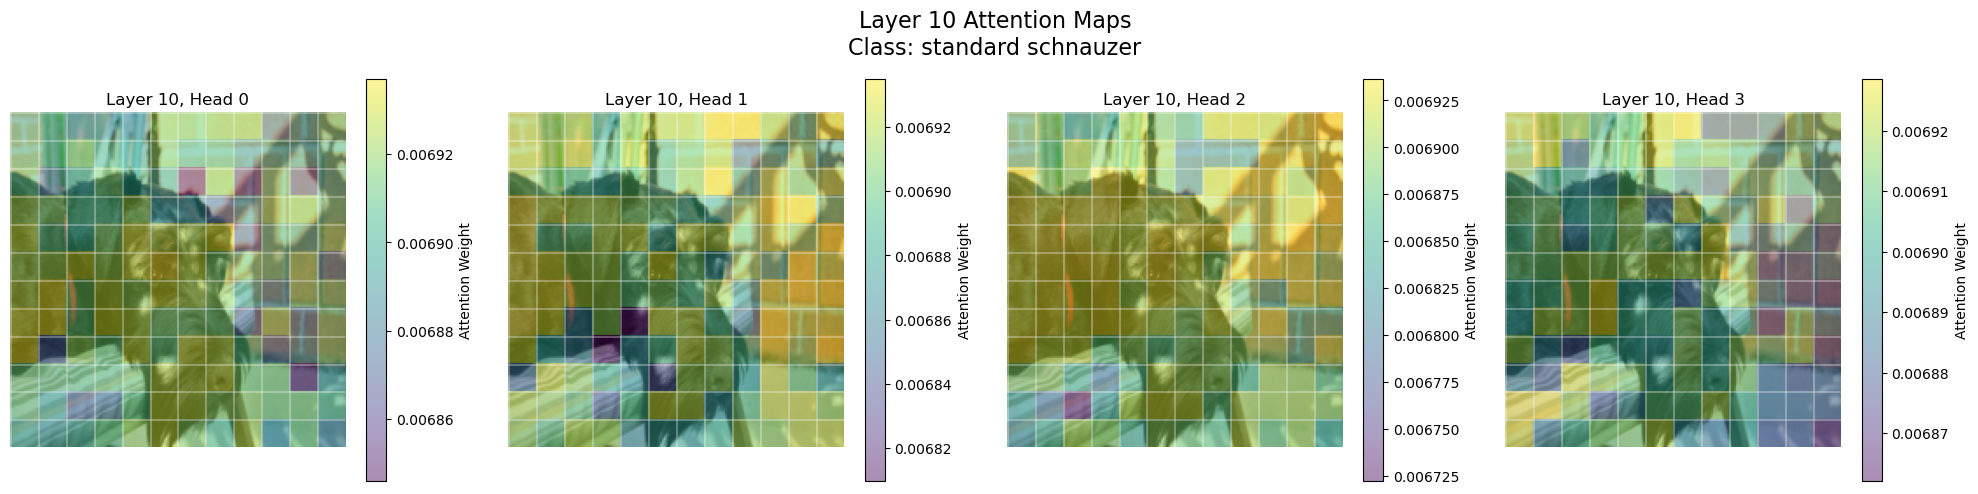

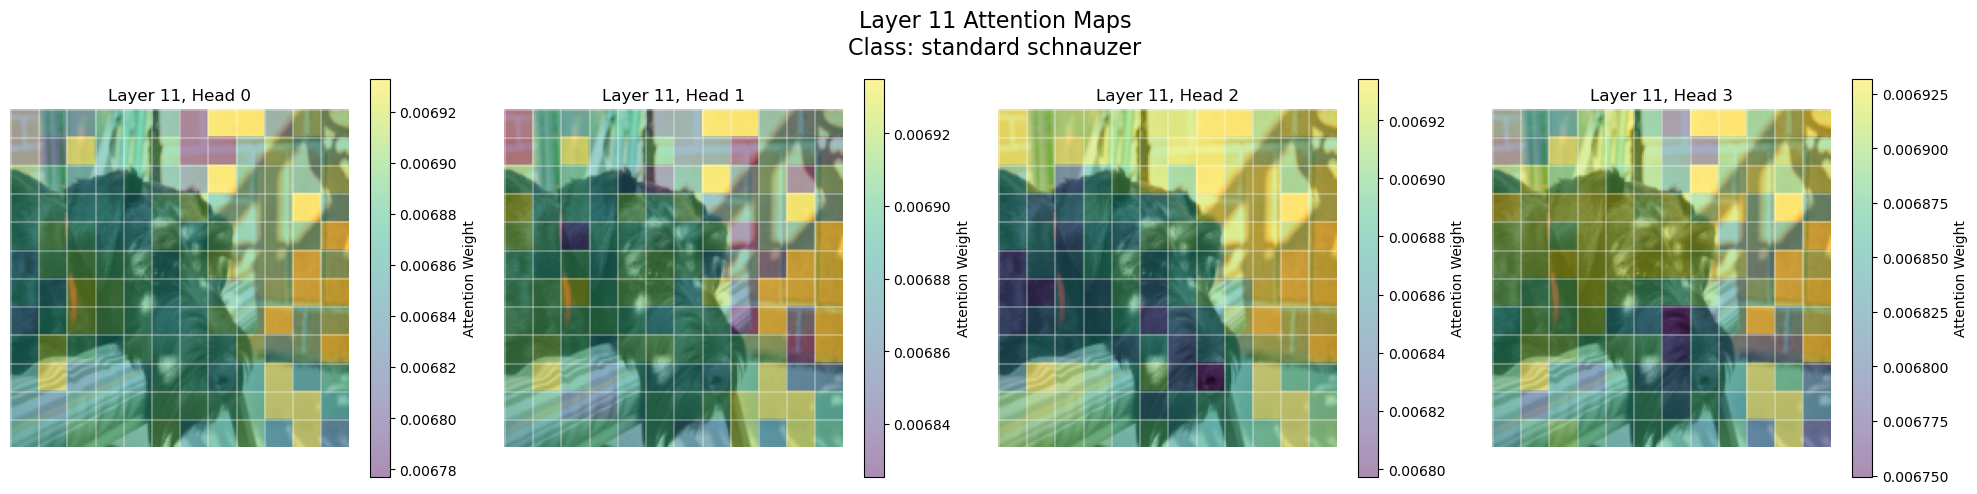

In [4]:
with open('data/imagenet/imagenet1000_clsidx_to_labels.txt', 'r') as f:
    class_labels = eval(f.read())
random_indices = random.sample(range(len(test_loader.dataset)), 1)

for i in random_indices:
    class_idx = test_loader.dataset[i][1]
    class_name = class_labels[class_idx]
    print(f"\nImage {i} class: {class_name} (index: {class_idx})")
    
    for layer in range(n_blocks):
        fig, axes = plt.subplots(1, min(n_heads, 4), figsize=(20, 5))
        if n_heads == 1:
            axes = [axes]
            
        for head in range(min(n_heads, 4)):  # Show up to 4 heads
            model.visualize_attention(
                images=test_loader.dataset[i][0].unsqueeze(0).to('cuda'),
                layer_idx=layer,
                head_idx=head,
                alpha=0.45,
                ax=axes[head]
            )
        
        plt.suptitle(f'Layer {layer} Attention Maps\nClass: {class_name}', size=16)
        plt.tight_layout()
        plt.show()

<h1> Visualize Class Separations </h1>

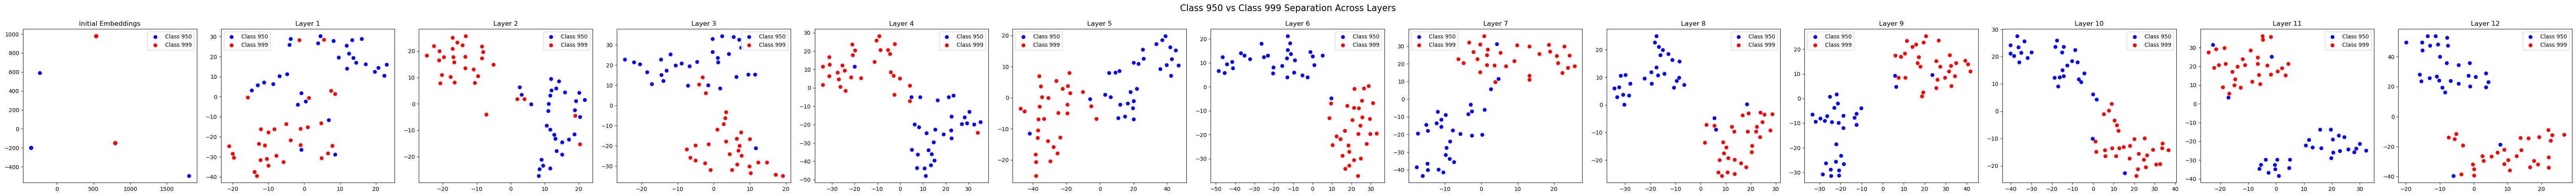

In [ ]:
model.visualize_class_separation(
    class_idx1=950,
    class_idx2=999,
    k=30,
    perplexity=10,
    dataloader=train_loader,
    # save_path='class_separation.png'
)